In [1]:
# Importing Packages

import numpy as np
import matplotlib.pyplot as plt
import time

from typing import Optional, Union

import jax
import jax.numpy as jnp
from jax.scipy.special import erf
from jax import jit, vmap, block_until_ready, config

from rl_algos.ppo_cnn import PPO_make_train

In [2]:
# Seeding everything

seed = 30

rng = jax.random.PRNGKey(seed)
rng, _rng = jax.random.split(rng)

In [4]:
# Defining Cairo Params and RL Params

tau_0 = 0.398
kappa = 20.0
chi = 0.65 * 2. * jnp.pi
kerr = 0.002
gamma = 1/140
time_coeff = 10.0
snr_coeff = 10.0
smoothness_coeff = 1.0
smoothness_baseline_scale = 1.0
apply_smoothing = False
bandwidth = 50.0
freq_relative_cutoff = 0.02
bandwidth_coeff = 100.0
apply_bandwidth_constraint = True
n0 = 43
res_amp_scaling = 1/0.43
actual_max_photons = n0 * (1 - jnp.exp(-0.5 * kappa * tau_0))**2
print(f"Rough Max Photons: {n0}")
print(f"Actual Max Photons: {actual_max_photons}")
nR = 0.01
snr_scale_factor = 1.9
gamma_I = 1/140
num_t1 = 5.0
photon_gamma = 1/1500
init_fid = 1 - 1e-4
photon_weight = 4.0

env_config = {"kappa": kappa,
    "chi": chi,
    "kerr": kerr,
    "time_coeff": time_coeff,
    "snr_coeff": snr_coeff,
    "smoothness_coeff": smoothness_coeff,
    "smoothness_baseline_scale": smoothness_baseline_scale,
    "apply_smoothing": apply_smoothing,
    "bandwidth": bandwidth,
    "freq_relative_cutoff": freq_relative_cutoff,
    "bandwidth_coeff": bandwidth_coeff,
    "apply_bandwidth_constraint": apply_bandwidth_constraint,
    "n0": n0,
    "tau_0": tau_0,
    "res_amp_scaling": res_amp_scaling,
    "nR": nR,
    "snr_scale_factor": snr_scale_factor,
    "gamma_I": gamma_I,
    "photon_gamma": photon_gamma,
    "num_t1": num_t1,
    "init_fid": init_fid,
    "photon_weight": photon_weight
}

num_envs = 256
num_updates = 6000
config = {
    "LR": 3e-4,
    "NUM_ENVS": num_envs,
    "NUM_STEPS": 1,
    "NUM_UPDATES": num_updates,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": int(num_envs / 64),
    "CLIP_EPS": 0.2,
    "VALUE_CLIP_EPS": 0.2,
    "ENT_COEF": 0.0,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "LAYER_SIZE": 64,
    "KERNEL_SIZE": 11,
    "ENV_NAME": "single_langevin_env",
    "ENV_PARAMS": env_config,
    "ANNEAL_LR": False,
    "DEBUG": True,
    "DEBUG_ACTION": False,
    "PRINT_RATE": 100,
    "ACTION_PRINT_RATE": 100,
}

Rough Max Photons: 43
Actual Max Photons: 41.40804860100575


In [5]:
single_train = jit(PPO_make_train(config), static_argnums=-1)

print(f"Starting a Run of {num_updates} Updates")
start = time.time()
single_result = single_train(
    _rng, 
    num_envs)
end = time.time()
print(f"time taken: {end - start}")

Starting a Run of 6000 Updates
global update: 100
reward: -1261.1592800116796
max pF: 1.3010502903182417
max photon: 8.883865990675986
photon time: 0.5486737012761044
smoothness: 0.21084206180567633
bandwidth: 237.9545454545455
global update: 200
reward: -891.4002570606538
max pF: 1.947966355018123
max photon: 15.488239906728268
photon time: 0.6608119298022948
smoothness: 0.12448156214685535
bandwidth: 237.92355371900828
global update: 300
reward: -616.6886031117913
max pF: 1.6664013474517225
max photon: 17.066940315067768
photon time: 0.35201935336472434
smoothness: 0.05848943275186453
bandwidth: 237.11776859504135
global update: 400
reward: -589.2816050488584
max pF: 1.72357100473207
max photon: 16.700529094785452
photon time: 0.2976667215249257
smoothness: 0.052826335565850605
bandwidth: 237.11776859504135
global update: 500
reward: -565.0479272644118
max pF: 1.6403696719626273
max photon: 15.72329081967473
photon time: 0.31100009795928474
smoothness: 0.046845039820730294
bandwidth:

In [1]:
import flax.linen as nn
import jax, jax.numpy as jnp

In [18]:
# valid padding

layer = nn.Conv(1, kernel_size=(7,), padding='SAME')
input = jnp.ones((256, 121, 1))
# out, variables = layer.init_with_output(jax.random.key(0), jnp.ones((1, 8, 3)))
out, variables = layer.init_with_output(jax.random.key(0), input)

def b_func(x):
    out, variables = layer.init_with_output(jax.random.key(0), x)
    return out

jax.tree_util.tree_map(jnp.shape, variables)

{'params': {'bias': (1,), 'kernel': (7, 1, 1)}}

In [19]:
out.shape

(256, 121, 1)

In [20]:
j_func = jax.jit(b_func)
out_s = j_func(input)
%time out_s = j_func(input)
print(out_s.shape)

CPU times: user 6.7 ms, sys: 275 µs, total: 6.98 ms
Wall time: 5.58 ms
(256, 121, 1)


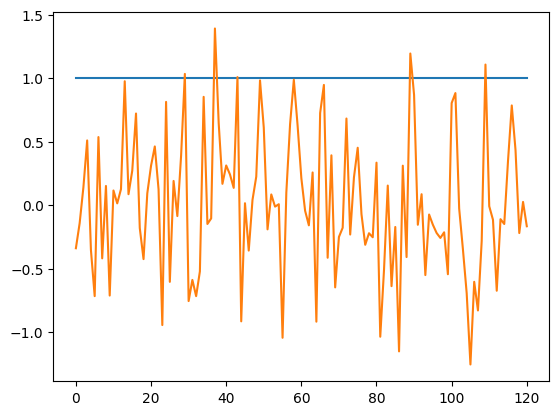

In [46]:
plt.plot(input.flatten())
plt.plot(out.flatten())

In [5]:
from utils import photon_env_dicts

env = photon_env_dicts()[config["ENV_NAME"]](**config["ENV_PARAMS"])

In [6]:
# Extracting Results

metrics = single_result["metrics"]

rewards = metrics["reward"]
max_pFs = metrics["max pF"]
max_photons = metrics["max photon"]
photon_times = metrics["photon time"]
smoothnesses = metrics["smoothness"]
# bandwidths = metrics["bandwidths"]
actions = metrics["action"]

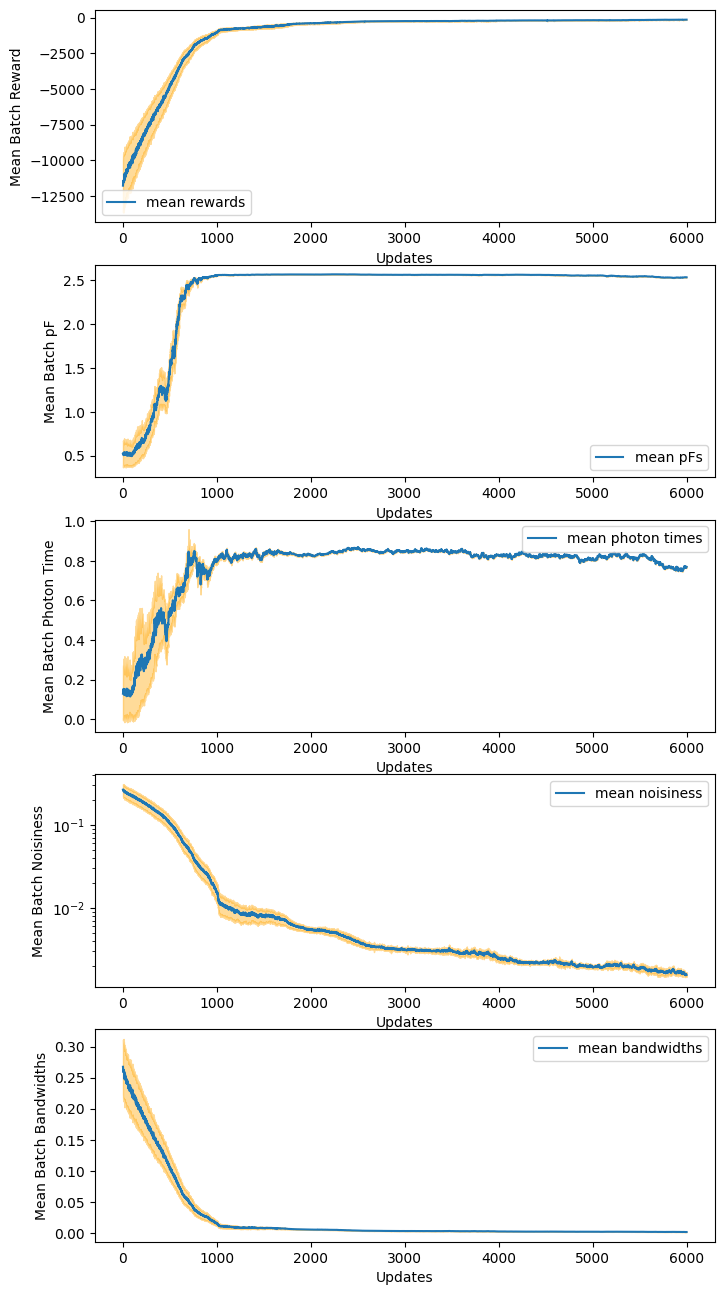

In [7]:
from utils import plot_learning

plot_learning(
    rewards=rewards,
    max_pFs=max_pFs,
    photon_times=photon_times,
    smoothnesses=smoothnesses,
    bandwidths=smoothnesses,
)

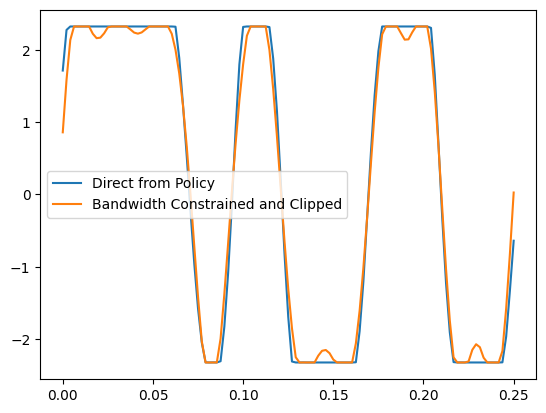

In [8]:
raw_final_action = -jnp.mean(actions, axis=1)[-1]
raw_transformed_action = env.prepare_action(raw_final_action)
env.kernel = env.default_params.gauss_kernel
smooth_final_action = env.drive_smoother(raw_transformed_action)

plt.plot(env.ts_action, raw_final_action, label='Direct from Policy')
plt.plot(env.ts_action, raw_transformed_action / env.a0, label='Bandwidth Constrained and Clipped')
# plt.plot(env.ts_action, smooth_final_action, label='Smoothed')
plt.legend()
plt.show()